In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru")

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
import json
# Open and load JSON file
with open('/home/jupyter/datasphere/synthetic_dataset/samples_8.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [6]:
pip install seqeval

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import random
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from seqeval.metrics import classification_report
from datasets import load_dataset

In [8]:
unique_labels = ['address', 'email', 'fio', 'ip', 'ipv6', 'login', 'org', 'password', 'phone']

In [9]:
import random
from itertools import chain
from typing import Any, Dict, List, Tuple

def sample_and_split_diverse(
    data: Dict[Any, Dict[Any, Dict[Any, Dict[Any, List[Dict]]]]],
    n_samples: int,
    val_ratio: float,
    seed: int = None
) -> Tuple[Tuple[List[str], List[Dict]], Tuple[List[str], List[Dict]]]:
    """
    Perform stratified sampling across (log_env, length) groups so that
    both train and val contain entries from each group.

    Args:
        data: nested dict of shape
              data[log_env][length][template][lang] -> list of {text, spans}
        n_samples: total number of examples (train + val)
        val_ratio: fraction of examples for validation
        seed: random seed for reproducibility

    Returns:
        ((train_texts, train_spans), (val_texts, val_spans))
    """
    if seed is not None:
        random.seed(seed)

    # 1. Flatten into groups
    groups: List[Tuple[Tuple[Any, Any], List[Dict]]] = []
    for log_env_val, lengths in data.items():
        for length_val, templates in lengths.items():
            entries = []
            for tmpl in templates.values():
                for lang_list in tmpl.values():
                    entries.extend(lang_list)
            if entries:
                groups.append(((log_env_val, length_val), entries))

    # Compute total available entries
    total_entries = sum(len(entries) for _, entries in groups)
    print('total_entries:', total_entries)
    if total_entries < n_samples:
        raise ValueError(f"Not enough total examples: {total_entries} < {n_samples}")

    n_val = int(n_samples * val_ratio)
    n_train = n_samples - n_val

    train_samples: List[Dict] = []
    val_samples:   List[Dict] = []

    # 2. For each group, allocate proportional samples then split
    acc_train, acc_val = 0, 0
    for (env_len, entries) in tqdm(groups):
        group_size = len(entries)
        # number of samples to take from this group
        group_n = max(1, int(group_size / total_entries * n_samples))
        # adjust last group to exactly fill
        if acc_train + acc_val + group_n > n_samples:
            group_n = n_samples - (acc_train + acc_val)

        # number of val samples from this group
        group_val_n = int(group_n * val_ratio)
        group_train_n = group_n - group_val_n

        # sample without replacement
        sampled = random.sample(entries, group_n)
        val_subset   = sampled[:group_val_n]
        train_subset = sampled[group_val_n:]

        val_samples.extend(val_subset)
        train_samples.extend(train_subset)
        acc_val   += len(val_subset)
        acc_train += len(train_subset)

    # 3. If rounding left us short, fill remaining slots from the pools
    def fill(samples: List[Dict], pool: List[Dict], need: int):
        if need <= 0:
            return
        remaining = [e for e in pool if e not in samples]
        samples.extend(random.sample(remaining, need))

    fill(val_samples,   list(chain.from_iterable(g for _, g in groups)), n_val - len(val_samples))
    fill(train_samples, list(chain.from_iterable(g for _, g in groups)), n_train - len(train_samples))

    # 4. Unpack texts and spans
    train_texts = [e['text'] for e in train_samples]
    train_spans = [e['spans'] for e in train_samples]
    val_texts   = [e['text'] for e in val_samples]
    val_spans   = [e['spans'] for e in val_samples]

    return ((train_texts, train_spans), (val_texts, val_spans))

In [8]:
(data_train, ner_train), (data_val, ner_val) = sample_and_split_diverse(data, 1024, 0.05)

total_entries: 167600


100%|██████████| 145/145 [00:00<00:00, 87886.43it/s]


In [9]:
len(data_train), len(data_val), data_train[14], ner_train[14]

NameError: name 'data_train' is not defined

In [10]:
data_log = ['80.97.168.58 - gorshkovnikon [Тимофеев Серафим Антонович] (email: viktor15@example.net, pass: _7Ys%IVQp2) phone=8 826 587 31 88 addr="к. Армавир, наб. Грибоедова, д. 9/3 стр. 5/3, 937143" org=Медведева и партнеры ipv6=64be:ec33:33f1:1207:5d95:7f1:8710:a5','A support ticket was created by user jeffrey97 from organization Hill-Hall. The ticket relates to an issue reported by (575)679-5357x44829. The affected client has IP address 9468:d568:5c7e:3ece:55c2:8542:2c96:8ca1 and client ID 79dbb385-04e2-43ca-a6ec-dbd0ca04b741.']
ner_data = [[
  {
    "label": "ip",
    "start": 1,
    "end": 13,
    "value": "80.97.168.58"
  },
  {
    "label": "login",
    "start": 16,
    "end": 29,
    "value": "gorshkovnikon"
  },
  {
    "label": "fio",
    "start": 31,
    "end": 57,
    "value": "Тимофеев Серафим Антонович"
  },
  {
    "label": "email",
    "start": 67,
    "end": 87,
    "value": "viktor15@example.net"
  },
  {
    "label": "password",
    "start": 95,
    "end": 105,
    "value": "_7Ys%IVQp2"
  },
  {
    "label": "phone",
    "start": 113,
    "end": 128,
    "value": "8 826 587 31 88"
  },
  {
    "label": "address",
    "start": 135,
    "end": 187,
    "value": "к. Армавир, наб. Грибоедова, д. 9/3 стр. 5/3, 937143"
  },
  {
    "label": "org",
    "start": 193,
    "end": 213,
  },
  {
    "label": "ipv6",
    "start": 219,
    "end": 256,
    "value": "64be:ec33:33f1:1207:5d95:7f1:8710:a5a"
  }
],
[{'label': 'login', 'start': 38, 'end': 47, 'value': 'jeffrey97'},
 {'label': 'org', 'start': 66, 'end': 75, 'value': 'Hill-Hall'},
 {'label': 'phone', 'start': 120, 'end': 139, 'value': '(575)679-5357x44829'},
 {'label': 'ipv6',
  'start': 176,
  'end': 215,
  'value': '9468:d568:5c7e:3ece:55c2:8542:2c96:8ca1'}]]

In [10]:
def prepared_data(data_log,ner_data,unique_labels):
    df = pd.DataFrame({
    "sentence": data_log,
    "ner": ner_data,
  })
  #Creat label dictionary
    unique_labels_ner = ["O"] + sorted([f"B-{e}" for e in unique_labels] + [f"I-{e}" for e in unique_labels])
    label2id = {label: idx for idx, label in enumerate(unique_labels_ner)}
    id2label = {v: k for k, v in label2id.items()}
  
  # Tokenize text
    tokenized = df["sentence"].apply(lambda x: tokenizer.encode_plus(
        x,
        add_special_tokens=True,  # Adds [CLS] and [SEP]
        max_length=256,           # Pad/truncate to max length
        padding='max_length',
        truncation=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_tensors='pt'       # Return PyTorch tensors
    ))
    df["input_ids"] = tokenized.apply(lambda x: x["input_ids"].squeeze(0))
    df["attention_mask"] = tokenized.apply(lambda x: x["attention_mask"].squeeze(0))
    df["offset_mapping"] = tokenized.apply(lambda x: x["offset_mapping"].squeeze(0))
    return df,label2id,id2label,unique_labels_ner

# df,label2id,id2label,unique_labels_ner = prepared_data(data_train,ner_train,unique_labels)
# df_val,_,_,_ = prepared_data(data_val,ner_val,unique_labels)

In [11]:
df.head()

NameError: name 'df' is not defined

In [12]:
def mark_label(labels,idx,label2id,label_ner,start_ner =-1,start_token = 1):
    if (start_token < start_ner):
        labels[idx] = label2id[f"B-{label_ner}"]
    else:
        labels[idx] = label2id[f"I-{label_ner}"]
    return labels

In [13]:
def create_labels(ners,offsets,label2id):
    total_labels = []
    for ner,offset in tqdm(zip(ners,offsets)):
        labels = [label2id["O"]] * len(offset)
        idx = 0
        for item in offset:
            start_token = item[0]
            end_token = item[1]
            if start_token == 0 and end_token == 0:
                labels[idx] = -100 
            else:
                for entity in ner:
                    start_ner = entity["start"]
                    end_ner = entity["end"]
                    label_ner = entity["label"]
                    if end_token >= start_ner and end_token < end_ner:
                        labels = mark_label(labels,idx,label2id,label_ner,start_ner,start_token)
                        break
                    elif end_ner > (start_token +1) and start_token > start_ner:
                        labels = mark_label(labels,idx,label2id,label_ner)
                        break
            idx +=1
        total_labels.append(labels)
    return total_labels
# df['labels'] = create_labels(df["ner"],df["offset_mapping"],label2id)
# df_val['labels'] = create_labels(df_val["ner"],df_val["offset_mapping"],label2id)

In [15]:
df['ner'][1]

[{'label': 'ipv6',
  'start': 212,
  'end': 250,
  'value': '6957:32cd:4588:e09f:e92e:2690:ce4e:597'},
 {'label': 'email',
  'start': 251,
  'end': 276,
  'value': 'oktjabrina_86@hotmail.com'}]

In [16]:
df["sentence"][0]

'127.0.0.1 - fedosi_84 - [24/Jul/2025:20:54:49 ] "DELETE search HTTP/2" 500 126733 "https://www.ip.org/explore/appterms.php" "Mozilla/5.0 (X11; Linux x86_64; rv:1.9.7.20) Gecko/5613-04-30 17:30:16 Firefox/3.8" с. Объячево, ул. Клубная, д. 255, 415586 rao.ru F%oz7IjV02'

In [17]:
df

,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,127.0.0.1 - fedosi_84 - [24/Jul/2025:20:54:49 ...,"[{'label': 'login', 'start': 13, 'end': 22, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 15, 0, 0,..."
1,"127.0.0.1 - - [20:54:49] ""POST list/posts/sear...","[{'label': 'ipv6', 'start': 212, 'end': 250, '...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1.2.3.4 - dorofeevasofija [2025-07-24] ""PATCH ...","[{'label': 'login', 'start': 11, 'end': 26, 'v...","[tensor(0), tensor(23644), tensor(30073), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 6, 15, 15, 15, 15, 15, 15, 0, ..."
3,"1.2.3.4 - agafonovaivanna [2025-07-24] ""DELETE...","[{'label': 'login', 'start': 11, 'end': 26, 'v...","[tensor(0), tensor(23644), tensor(30073), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 6, 15, 15, 15, 15, 15, 0, 0, 0..."
4,"127.0.0.1 - - [20:54:49] ""POST tags HTTP/1.0"" ...","[{'label': 'ipv6', 'start': 243, 'end': 281, '...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
968,The user Туров Моисей Глебович from organizati...,"[{'label': 'fio', 'start': 10, 'end': 31, 'val...","[tensor(0), tensor(581), tensor(11483), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 3, 12, 12, 12, 12, 12, 12, 12, 0,..."
969,log_type=insurance_claim\nanike1972 I%dl91at0R...,"[{'label': 'login', 'start': 26, 'end': 35, 'v...","[tensor(0), tensor(5170), tensor(454), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 15, 15, ..."
970,An event occurred on email-56.keith-graves.com...,"[{'label': 'org', 'start': 85, 'end': 96, 'val...","[tensor(0), tensor(893), tensor(7016), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
971,127.0.0.1 - lukinmark [24/Jul/2025:20:54:52 ] ...,"[{'label': 'login', 'start': 13, 'end': 22, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 0, 0, 0, 0, 0..."


In [18]:
df['ner'][0]

[{'label': 'login', 'start': 13, 'end': 22, 'value': 'fedosi_84'},
 {'label': 'address',
  'start': 210,
  'end': 250,
  'value': 'с. Объячево, ул. Клубная, д. 255, 415586'},
 {'label': 'password', 'start': 258, 'end': 268, 'value': 'F%oz7IjV02'}]

In [14]:
def test_tokens(labels,input_ids,offset):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_labels = [id2label[l] if l != -100 else "IGNORED" for l in labels]
    for t, l, o in zip(tokens, token_labels, offset):
        print(f"{t:15} → {l}, {o}")
test_tokens(df['labels'][0],df['input_ids'][0],df["offset_mapping"][0])

NameError: name 'df' is not defined

In [15]:
class TokenClassifierHead(nn.Module):
    def __init__(self, hidden_size, num_labels):
        """
        Classification head for token-level predictions.
        """
        super(TokenClassifierHead, self).__init__()
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        """
        Args:
            x: tensor of shape [batch_size, seq_len, hidden_size]
        Returns:
            logits: tensor of shape [batch_size, seq_len, num_labels]
        """
        logits = self.classifier(x)
        return logits
    

In [16]:
class BERTForNER(nn.Module):
    def __init__(self, model, num_labels):
        """
        BERT + token classification head for NER.
        """
        super(BERTForNER, self).__init__()
        self.bert = model
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = TokenClassifierHead(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        """
        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]
            token_type_ids: [batch_size, seq_len]
        Returns:
            logits: [batch_size, seq_len, num_labels]
        """
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        # Get all token embeddings
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        sequence_output = self.dropout(sequence_output)


        # Predict logits for each token
        logits = self.classifier(sequence_output)  # [batch_size, seq_len, num_labels]
        return logits


In [17]:
from torch.utils.data import Dataset

class NERDataset(Dataset):
    def __init__(self, input_ids,attention_mask, labels):
        """
        Args:
            encodings: tokenizer output (input_ids, attention_mask, etc.)
            labels: list of BIO tag IDs aligned with tokens
        """
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item ={}
        item['input_ids'] =  torch.tensor(self.input_ids[idx])
        item['attention_mask']  = torch.tensor(self.attention_mask[idx])
        item["labels"] =  torch.tensor(self.labels[idx])
        return item

In [16]:
def train(model, df, df_val, unique_labels_ner, epochs):
    num_labels = len(unique_labels_ner)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == 'cuda':
        torch.cuda.empty_cache()

    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Define class weights
    # Example: make class 0 5x more important than others
    class_weights = torch.ones(num_labels, device=device) * 5
    class_weights[0] = 0.2  # Penalize class 0 misclassification more

    criterion = CrossEntropyLoss(weight=class_weights, ignore_index=-100)

    # Create dataloaders
    train_dataset = NERDataset(df['input_ids'], df['attention_mask'], df['labels'])
    val_dataset = NERDataset(df_val['input_ids'], df_val['attention_mask'], df_val['labels'])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss_train = 0.0

        for b_n, batch in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(
                logits.view(-1, num_labels),  # Flatten
                labels.view(-1)
            )
            # print(loss)

            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            if b_n % 50 == 0:
                print('train_loss:', loss.item())
                model.eval()
                total_loss_val = 0.0

                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        logits = model(input_ids, attention_mask)

                        loss = criterion(
                            logits.view(-1, num_labels),
                            labels.view(-1)
                        )
                        total_loss_val += loss.item()
                    print(torch.argmax(logits[0][:10].view(-1, num_labels), dim=-1), labels.view(-1)[:10])

                avg_loss_val = total_loss_val / len(val_loader)

                print(f"Epoch {epoch+1}/{epochs} batch {b_n}/{len(train_loader)} - Loss_val: {avg_loss_val:.4f}")

        avg_loss_train = total_loss_train / len(train_loader)

        # Validation phase
        model.eval()
        total_loss_val = 0.0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids, attention_mask)

                loss = criterion(
                    logits.view(-1, num_labels),
                    labels.view(-1)
                )
                total_loss_val += loss.item()

        avg_loss_val = total_loss_val / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Loss_train: {avg_loss_train:.4f}, Loss_val: {avg_loss_val:.4f}")
    return

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = AutoModel.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru")
model = BERTForNER(base_model, len(unique_labels_ner)).to(device)

In [25]:
train(model,df,df_val,unique_labels_ner,2)

0it [00:00, ?it/s]

train_loss: 3.0757055282592773


1it [00:11, 11.98s/it]

tensor([ 4,  5,  7,  7,  5,  5,  5, 17,  4,  5], device='cuda:0') tensor([-100,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       device='cuda:0')
Epoch 1/2 batch 0/122 - Loss_val: 3.0332


20it [00:21,  1.09s/it]


KeyboardInterrupt: 

In [ ]:
# torch.save(model, "/home/jupyter/datasphere/project/model/bertner_1k_2ep.pth")

## Eval

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("/home/jupyter/datasphere/project/model/bertner_with_scheduler.pth", weights_only=False)

In [19]:
def predict(text, model, tokenizer, id2label, device="cuda"):
    """
    Run NER prediction on raw text.

    Args:
        text (str): Raw input text.
        model (nn.Module): Your trained BERTForNER model.
        tokenizer: Hugging Face tokenizer.
        id2label (dict): Mapping from label IDs to label names.
        device (str): "cpu" or "cuda".
    Returns:
        List of (token, predicted_label)
    """
    # Tokenize input text
    encoding = tokenizer.encode_plus(
        text,
        max_length=256,           # Pad/truncate to max length
        truncation=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_tensors='pt'       # Return PyTorch tensors
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Set model to eval mode
    model.eval()
    with torch.no_grad():
        # Forward pass
        logits = model(input_ids, attention_mask)
        predictions = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

    # Convert IDs to tokens and labels
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    # print(predictions)
    predicted_labels = [id2label[p.item()] for p in predictions[0]]
    filtered_results = []
    for token, label in zip(tokens, predicted_labels):
        filtered_results.append((token, label))
    # Filter out special tokens ([CLS], [SEP], [PAD])

    return filtered_results

In [21]:
inspect_id = 2

In [22]:
df_val['sentence'][inspect_id]

NameError: name 'df_val' is not defined

In [104]:
df_val['ner'][inspect_id]

[{'label': 'login', 'start': 7, 'end': 16, 'value': 'egor_2016'},
 {'label': 'ipv6',
  'start': 22,
  'end': 61,
  'value': '5ef3:bc09:73c7:9b62:4804:381c:4185:4433'},
 {'label': 'org',
  'start': 65,
  'end': 102,
  'value': 'РАО «Красильников, Громова и Архипов»'},
 {'label': 'password', 'start': 108, 'end': 118, 'value': 'p5Ux^7+g!d'}]

In [105]:
filtered_results = predict(df_val['sentence'][inspect_id], model, tokenizer, id2label, device="cuda")

In [113]:
df_val['sentence'][inspect_id],

('sshd: egor_2016 from 5ef3:bc09:73c7:9b62:4804:381c:4185:4433 on РАО «Красильников, Громова и Архипов» with p5Ux^7+g!d',)

In [106]:
filtered_results[:30]

['I-org',
 'O',
 'O',
 'O',
 'O',
 'B-login',
 'I-login',
 'I-login',
 'I-login',
 'O',
 'B-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6',
 'I-ipv6']

In [23]:
def visualization_result(results):
    
    output = str()
    last_tag = "O"
    
    for token, tag in results:
        if (tag[2:] if tag != "O" else tag) != last_tag:
            if last_tag != "O":
                output += f"</{last_tag.upper()}>"
            output += "\n"
            if tag != "O":
                output += f"<{tag[2:].upper()}>"
            last_tag = tag[2:] if tag != "O" else tag
        output += token
        
    return output

print(visualization_result(filtered_results))

NameError: name 'filtered_results' is not defined

In [34]:
preds = list(map(lambda x: x[1], filtered_results[:10]))
preds

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [35]:
token_labels = [id2label[l] if l != -100 else "IGNORED" for l in df_val["labels"][inspect_id]][1:11]
token_labels

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [36]:
print(classification_report([preds], [token_labels]))

ValueError: max() arg is an empty sequence

In [24]:
indices = [188, 315, 477, 583, 623, 683, 825, 843, 844, 888, 890, 903, 929, 942, 960, 1033, 1275, 1319, 1325, 1328, 1329, 1342, 1360, 1398, 1422, 
           1439, 1442, 1444, 1528, 1532, 1538, 1539, 1545, 1559, 1633, 1676, 1737, 1738, 1766, 1767, 1770, 1773, 1787, 1788, 1804, 1805, 1806, 1813,
           1886, 1895, 1906, 1916, 2052, 2059, 2103, 2149, 2151, 2153, 2172, 2228, 2280, 2305, 2418, 2487, 2490, 2541, 2588, 2604, 2683, 2721, 2805,
           2807, 2808, 2809, 2811, 2812, 2813, 2873, 2880, 2881, 2883, 2886, 2889, 3003, 3053, 3062, 3065, 3067, 3068, 3069, 3070, 3113, 3123, 3137,
           3389, 3391, 3497, 3499, 3505, 3543, 3618, 3666, 3671, 3735, 3764, 3771, 3825, 3830, 3835, 3837, 3842, 3847, 3848, 3855, 3974, 4108, 4109,
           4138, 4195, 4266, 4303, 4366, 4414, 4417, 4429, 4531, 4537, 4663, 4695, 4735, 4820, 4824, 4859, 4861, 4876, 4977, 4979, 4980, 4986, 5015,
           5057, 5127, 5156, 5203, 5205, 5261, 5263, 5264, 5265, 5290, 5361, 5373, 5458, 5484, 5599, 5611, 5663, 5817, 5818, 5911, 5913, 5992, 6002,
           6007, 6010, 6012, 6079, 6163, 6176, 6182, 6269, 6336, 6441, 6448, 6450, 6460, 6475, 6477, 6479, 6480, 6481, 6482, 6483, 6485, 6562, 6580,
           6583, 6584, 6585, 6588, 6589, 6590, 6593, 6594, 6595, 6679, 6703, 6704, 6708, 6821, 6828, 6899, 6908, 6941, 6994, 7252, 7300, 7372, 7379,
           7521, 7531, 7534, 7536, 7538, 7540, 7541, 7608, 7624, 7637, 7686, 7687, 7692, 7695, 7697, 7704, 7712, 7713, 7715, 7723, 7729, 7732, 7743,
           7791, 8171, 8182, 8185, 8194, 8285, 8503, 8712, 8733, 8971, 9047, 9089, 9100, 9106, 9215, 9243, 9259, 9263, 9334, 9341, 9346, 9368, 9404,
           9406, 9409, 9427, 9431, 9432, 9433, 9438, 9524, 9526, 9529, 9534, 9536, 9537, 9540, 9542, 9571, 9573, 9575, 9577, 9579, 9580, 9582, 9585,
           9586, 9589, 9592, 9593, 9744, 9768, 9875, 9876, 9878, 9975, 9976]


df_test = load_dataset("ai4privacy/pii-masking-400k")["train"]
df_test = df_test.select(indices)

def edit_json(input: str):
    json_dict = input
    json_new = list()
    for item in json_dict:
        label_mapping = {
            "PHONE": "phone",
            "PASSWORD": "password",
            "USERNAME": "login",
            "EMAIL": "email",
            "GIVENNAME": "fio",
            "SURNAME": "fio",
        }
        original_label = item["label"]
        item["label"] = label_mapping.get(original_label, original_label)
        item["start"] += 1
        item["end"] += 1
        if item["label"] in ["phone", "password", "login", "email", "fio"]:
            json_new.append(item)
    return json_new


df_test = df_test.map(lambda x: {"privacy_mask": edit_json(x["privacy_mask"])},
            batched=False,
            desc="Processing privacy masks")

df_test, label2id, id2label, unique_labels_ner = prepared_data(df_test["source_text"], df_test["privacy_mask"], unique_labels)
df_test['labels'] = create_labels(df_test["ner"], df_test["offset_mapping"], label2id)


df_test.head()

289it [00:01, 181.37it/s]


,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,Application completeness check: <br> Name: Mar...,"[{'label': 'fio', 'start': 44, 'end': 49, 'val...","[tensor(0), tensor(22559), tensor(9177), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(11...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 3,..."
1,"Therapy check-in: Client Alfried Wohlgenannt, ...","[{'label': 'fio', 'start': 26, 'end': 33, 'val...","[tensor(0), tensor(34354), tensor(5194), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(7)...","[-100, 0, 0, 0, 0, 0, 0, 3, 12, 3, 12, 12, 12,..."
2,The developmental evaluation of Niranjala Cone...,"[{'label': 'fio', 'start': 33, 'end': 42, 'val...","[tensor(0), tensor(581), tensor(10611), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 3, 12, 12, 12, 3, 12, 12..."
3,Mrs Vlada's developmental delay noted. Residen...,"[{'label': 'fio', 'start': 5, 'end': 10, 'valu...","[tensor(0), tensor(23022), tensor(310), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,<p>fatima.yavru09's medication plan overseen b...,"[{'label': 'login', 'start': 4, 'end': 18, 'va...","[tensor(0), tensor(2516), tensor(254), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 6, 15, 15, 15, 15, 15, 15, 0, ..."


In [25]:
df_test

,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,Application completeness check: <br> Name: Mar...,"[{'label': 'fio', 'start': 44, 'end': 49, 'val...","[tensor(0), tensor(22559), tensor(9177), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(11...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 3,..."
1,"Therapy check-in: Client Alfried Wohlgenannt, ...","[{'label': 'fio', 'start': 26, 'end': 33, 'val...","[tensor(0), tensor(34354), tensor(5194), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(7)...","[-100, 0, 0, 0, 0, 0, 0, 3, 12, 3, 12, 12, 12,..."
2,The developmental evaluation of Niranjala Cone...,"[{'label': 'fio', 'start': 33, 'end': 42, 'val...","[tensor(0), tensor(581), tensor(10611), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 3, 12, 12, 12, 3, 12, 12..."
3,Mrs Vlada's developmental delay noted. Residen...,"[{'label': 'fio', 'start': 5, 'end': 10, 'valu...","[tensor(0), tensor(23022), tensor(310), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,<p>fatima.yavru09's medication plan overseen b...,"[{'label': 'login', 'start': 4, 'end': 18, 'va...","[tensor(0), tensor(2516), tensor(254), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 6, 15, 15, 15, 15, 15, 15, 0, ..."
...,...,...,...,...,...,...
284,"For Full-time clients, financial structures in...","[{'label': 'fio', 'start': 81, 'end': 87, 'val...","[tensor(0), tensor(1175), tensor(4191), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
285,Structured finance deal includes documentation...,"[{'label': 'fio', 'start': 81, 'end': 88, 'val...","[tensor(0), tensor(16242), tensor(11917), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
286,Verifying REF-202207-1634 documentation for CA...,"[{'label': 'fio', 'start': 118, 'end': 127, 'v...","[tensor(0), tensor(1239), tensor(28023), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
287,Rights documentation for shareholders must be ...,"[{'label': 'login', 'start': 102, 'end': 126, ...","[tensor(0), tensor(11480), tensor(33033), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(6)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
# df_test["privacy_mask"]

In [27]:
df_test['labels'][0]

[-100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 12,
 3,
 12,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,

In [29]:
test_preds = predict(df_test['sentence'][inspect_id], model, tokenizer, id2label, device="cuda")
print(visualization_result(test_preds))


<ADDRESS><s></ADDRESS>
▁The▁developmental▁evaluation▁of
<FIO>▁Niranjala▁Conejera</FIO>
▁focuses▁on▁their▁ability▁to▁engage▁socially▁and▁perform▁physical▁tasks.
<PHONE>▁325.538.9412</PHONE>
▁identified▁by
<FIO>▁Madame▁Conejera</FIO>
▁in
<ADDRESS>▁Southamp</ADDRESS>
<ORG>ton▁Bishop's▁Waltham</ORG>
▁as▁a▁solid▁indicator▁of▁progress.</s>


In [30]:
id2label
[id2label[l] if l != -100 else "IGNORED" for l in df_test["labels"][inspect_id]]

['IGNORED',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-fio',
 'I-fio',
 'I-fio',
 'I-fio',
 'B-fio',
 'I-fio',
 'I-fio',
 'I-fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-fio',
 'I-fio',
 'I-fio',
 'I-fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED'

In [31]:
predict(df_test["sentence"][1], model, tokenizer, id2label, device="cuda")

[('<s>', 'I-address'),
 ('▁Therapy', 'O'),
 ('▁check', 'O'),
 ('-', 'I-address'),
 ('in', 'O'),
 (':', 'O'),
 ('▁Client', 'B-fio'),
 ('▁Al', 'B-fio'),
 ('fried', 'I-fio'),
 ('▁Wo', 'I-fio'),
 ('hl', 'I-fio'),
 ('gen', 'I-fio'),
 ('an', 'I-fio'),
 ('nt', 'I-fio'),
 (',', 'I-fio'),
 ('▁res', 'O'),
 ('iding', 'I-address'),
 ('▁at', 'O'),
 ('▁White', 'I-address'),
 ('▁Spring', 'I-address'),
 ('s', 'I-address'),
 (',', 'I-address'),
 ('▁FL', 'I-address'),
 ('.', 'O'),
 ('▁Conce', 'O'),
 ('r', 'O'),
 ('ns', 'O'),
 ('▁over', 'O'),
 ('▁height', 'O'),
 ('▁(', 'O'),
 ('150', 'O'),
 ('▁cm', 'I-address'),
 ('▁/', 'O'),
 ('▁4', 'O'),
 ("'", 'I-email'),
 ('▁11', 'O'),
 ('").', 'I-phone'),
 ('▁Prima', 'O'),
 ('ry', 'O'),
 ('▁contact', 'O'),
 (':', 'O'),
 ('▁+', 'B-phone'),
 ('11', 'I-phone'),
 ('-6', 'I-phone'),
 ('7.8', 'I-phone'),
 ('08.', 'I-phone'),
 ('01', 'I-phone'),
 ('95', 'I-phone'),
 ('.', 'O'),
 ('▁Co', 'O'),
 ('ordina', 'O'),
 ('tes', 'O'),
 ('▁record', 'O'),
 ('ed', 'O'),
 (':', 'O'),
 (

In [32]:
df_test

,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,Application completeness check: <br> Name: Mar...,"[{'label': 'fio', 'start': 44, 'end': 49, 'val...","[tensor(0), tensor(22559), tensor(9177), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(11...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 12, 3,..."
1,"Therapy check-in: Client Alfried Wohlgenannt, ...","[{'label': 'fio', 'start': 26, 'end': 33, 'val...","[tensor(0), tensor(34354), tensor(5194), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(7)...","[-100, 0, 0, 0, 0, 0, 0, 3, 12, 3, 12, 12, 12,..."
2,The developmental evaluation of Niranjala Cone...,"[{'label': 'fio', 'start': 33, 'end': 42, 'val...","[tensor(0), tensor(581), tensor(10611), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 3, 12, 12, 12, 3, 12, 12..."
3,Mrs Vlada's developmental delay noted. Residen...,"[{'label': 'fio', 'start': 5, 'end': 10, 'valu...","[tensor(0), tensor(23022), tensor(310), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 3, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,<p>fatima.yavru09's medication plan overseen b...,"[{'label': 'login', 'start': 4, 'end': 18, 'va...","[tensor(0), tensor(2516), tensor(254), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 6, 15, 15, 15, 15, 15, 15, 0, ..."
...,...,...,...,...,...,...
284,"For Full-time clients, financial structures in...","[{'label': 'fio', 'start': 81, 'end': 87, 'val...","[tensor(0), tensor(1175), tensor(4191), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
285,Structured finance deal includes documentation...,"[{'label': 'fio', 'start': 81, 'end': 88, 'val...","[tensor(0), tensor(16242), tensor(11917), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
286,Verifying REF-202207-1634 documentation for CA...,"[{'label': 'fio', 'start': 118, 'end': 127, 'v...","[tensor(0), tensor(1239), tensor(28023), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(3)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
287,Rights documentation for shareholders must be ...,"[{'label': 'login', 'start': 102, 'end': 126, ...","[tensor(0), tensor(11480), tensor(33033), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(6)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [33]:
for item in df_test['labels']:
    if len(item) > 256:
        print(item)

In [34]:
id2label

{0: 'O',
 1: 'B-address',
 2: 'B-email',
 3: 'B-fio',
 4: 'B-ip',
 5: 'B-ipv6',
 6: 'B-login',
 7: 'B-org',
 8: 'B-password',
 9: 'B-phone',
 10: 'I-address',
 11: 'I-email',
 12: 'I-fio',
 13: 'I-ip',
 14: 'I-ipv6',
 15: 'I-login',
 16: 'I-org',
 17: 'I-password',
 18: 'I-phone'}

In [35]:
df_test["labels"][i]

NameError: name 'i' is not defined

In [89]:
len([id2label[l] for l in df_test["labels"][3] if l != -100])

63

TypeError: index expected at least 1 argument, got 0

In [90]:
len(predict(df_test["sentence"][3], model, tokenizer, id2label, device="cuda"))

65

100%|██████████| 289/289 [00:04<00:00, 63.65it/s]


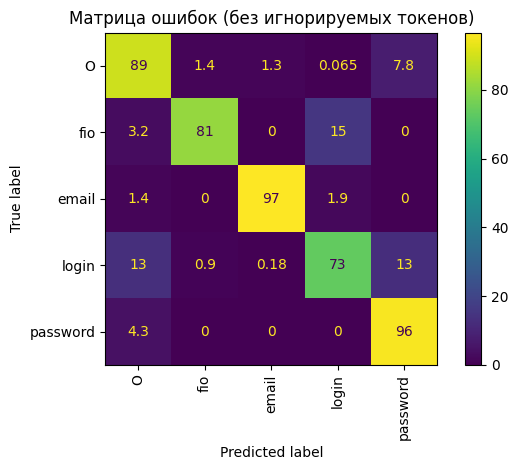

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Все возможные метки (включая 'O' и BIO-теги)
labels = [
    'O',
    'fio',
    'email',
    'login',
    'password',
]

y_true = []
y_pred = []

for i in tqdm(range(df_test.shape[0])):
    # Получаем предсказанные метки (полная последовательность)
    preds = predict(df_test["sentence"][i], model, tokenizer, id2label, device="cuda")
    preds_labels = list(map(lambda x: x[1], preds))  # Извлекаем только метки (не логиты)
    
    # Получаем истинные метки (с -100 для игнорируемых токенов)
    true_labels_raw = df_test["labels"][i]  # Например: [3, -100, 0, 4, ...]
    
    # Фильтруем preds_labels и true_labels: оставляем только токены, где true_labels != -100
    filtered_preds = []
    filtered_true = []
    
    for pred, true_idx in zip(preds_labels, true_labels_raw):
        if true_idx != -100:
            filtered_preds.append(pred[2:] if len(pred) > 2 else pred)
            filtered_true.append(id2label[true_idx][2:] if len(id2label[true_idx]) > 2 else id2label[true_idx])
    
    # Проверяем, что после фильтрации длины совпадают
    if len(filtered_preds) != len(filtered_true):
        print(f"Ошибка в строке {i}: длины не совпадают после фильтрации")
        print(f"Предсказано: {filtered_preds}")
        print(f"Истинные: {filtered_true}")
        continue  # Пропускаем проблемные примеры
    
    y_true.extend(filtered_true)
    y_pred.extend(filtered_preds)

# Построение матрицы ошибок (только для корректных меток)
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay((cm.T / np.sum(cm, axis=1)).T * 100, display_labels=labels)
disp.plot()
plt.xticks(rotation=90)
plt.title("Матрица ошибок (без игнорируемых токенов)")
plt.tight_layout()
plt.show()

In [38]:
y_true

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'fio',
 'fio'

In [39]:
y_pred

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'O',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'org',
 'org',
 'O',
 'O',
 'org',
 'O',
 'O',
 'O',
 'address',
 'address',
 'O',
 'address',
 'address',
 'address',
 'O',
 'O',
 'O',
 'ip',
 'ip',
 'O',
 'O',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'password',
 'password',
 'password',
 'phone',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'fio',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'fio',
 'org',
 'fio',
 'fio',
 'O',
 'fio',
 'address',
 'address',
 'address',
 'fio',
 'address',
 'address',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'fio',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'phone',
 'O',
 

In [37]:
print(classification_report([y_true], [y_pred]))

              precision    recall  f1-score   support

     assword       0.21      0.80      0.33        44
      ddress       0.00      0.00      0.00         0
        hone       0.00      0.00      0.00         0
          io       0.17      0.23      0.20       202
        mail       0.08      0.46      0.13        39
        ogin       0.51      0.63      0.56        99
           p       0.00      0.00      0.00         0
         pv6       0.00      0.00      0.00         0
          rg       0.00      0.00      0.00         0

   micro avg       0.09      0.42      0.15       384
   macro avg       0.11      0.24      0.14       384
weighted avg       0.25      0.42      0.30       384



In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [
 'O',
 'B-fio',
 'B-phone',
 'B-email',
 'B-login',
 'B-password',
 'I-fio',
 'I-phone',
 'I-email',
 'I-login',
 'I-password'
]

y_true = list()
y_pred = list()
for i in tqdm(range(df_test.shape[0])):
    preds_labels = predict(df_test["sentence"][i], model, tokenizer, id2label, device="cuda")
    preds_labels = list(map(lambda x: x[1], preds_labels))
    preds_labels = [item for item in preds_labels if item != -100]
    # print(preds_labels)
    true_labels = [id2label[l] for l in df_test["labels"][i] if l != -100]
    
    y_true.extend(true_labels)
    y_pred.extend(preds_labels)
    if len(y_true) != len(y_pred):
        print(y_pred)
        print(y_true)
        print(len(y_pred))
        print(len(y_true))
        break
        
           


cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.title("Матрица ошибок")
plt.show()

  1%|          | 3/289 [00:00<00:05, 47.87it/s]

[('▁Application', 'O'), ('▁complete', 'O'), ('ness', 'O'), ('▁check', 'O'), (':', 'O'), ('▁<', 'O'), ('br', 'O'), ('>', 'O'), ('▁Name', 'O'), (':', 'O'), ('▁Mara', 'B-fio'), ('h', 'I-fio'), ('▁Pey', 'I-fio'), ('r', 'I-fio'), ('illes', 'I-fio'), ('▁<', 'O'), ('br', 'O'), ('>', 'O'), ('▁Job', 'O'), ('▁Title', 'O'), (':', 'O'), ('▁The', 'O'), ('rap', 'O'), ('ist', 'O'), (',', 'O'), ('▁drama', 'O'), ('▁<', 'O'), ('br', 'O'), ('>', 'O'), ('▁Z', 'O'), ('IP', 'O'), ('▁Code', 'O'), (':', 'O'), ('▁207', 'I-address'), ('20', 'I-address'), ('▁<', 'O'), ('br', 'O'), ('>', 'O'), ('▁', 'O'), ('IBA', 'O'), ('N', 'O'), (':', 'O'), ('▁US', 'O'), ('13', 'I-phone'), ('78', 'I-phone'), ('47', 'I-phone'), ('35', 'I-phone'), ('98', 'I-phone'), ('A', 'I-phone'), ('LY', 'I-phone'), ('50', 'I-phone'), ('71', 'I-phone'), ('▁<', 'O'), ('br', 'O'), ('>', 'O'), ('▁Account', 'O'), ('▁Number', 'O'), (':', 'O'), ('▁144', 'B-phone'), ('97', 'I-phone'), ('12', 'I-phone'), ('48', 'I-phone'), ('337', 'I-phone'), ('31', '

ValueError: Found input variables with inconsistent numbers of samples: [276, 275]

In [73]:
predict(df_test["sentence"][i], model, tokenizer, id2label, device="cuda")

[('▁This', 'O'),
 ('▁agreement', 'O'),
 ('▁requires', 'O'),
 ('▁share', 'O'),
 ('holder', 'O'),
 ('s', 'O'),
 ('▁to', 'O'),
 ('▁valida', 'O'),
 ('te', 'O'),
 ('▁their', 'O'),
 ('▁documents', 'O'),
 ('▁using', 'O'),
 ('▁mari', 'O'),
 ('e', 'O'),
 ('-', 'O'),
 ('ther', 'I-login'),
 ('es', 'I-login'),
 ('19', 'I-login'),
 ('88', 'I-login'),
 ('.', 'O'),
 ('▁For', 'O'),
 ('▁updates', 'O'),
 (',', 'O'),
 ('▁check', 'O'),
 ('▁http', 'O'),
 ('://', 'O'),
 ('w', 'O'),
 ('hi', 'O'),
 ('tak', 'O'),
 ('er', 'O'),
 ('.', 'O'),
 ('net', 'O'),
 ('/', 'O'),
 ('▁or', 'O'),
 ('▁direct', 'O'),
 ('▁que', 'O'),
 ('ries', 'O'),
 ('▁to', 'O'),
 ('▁00', 'B-phone'),
 ('13', 'I-phone'),
 ('-6', 'I-phone'),
 ('0.5', 'I-phone'),
 ('97', 'I-phone'),
 ('.', 'I-phone'),
 ('25', 'I-phone'),
 ('12', 'I-phone'),
 ('.', 'O')]

In [60]:
for item in df_test['labels']:
    if len(item) > 256:
        print(item)

In [71]:
[id2label[l] if l != -100 else "IGNORED" for l in df_test["labels"][i]]

['IGNORED',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-login',
 'I-login',
 'I-login',
 'I-login',
 'I-login',
 'I-login',
 'I-login',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IGNORED',
 'IG